# Simulate Network Bursting Plot with Simulated MEA Data using NetPyNE

# Initiate Simulation Func and Bursting Plot Func.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, find_peaks
from scipy.stats import norm

def plot_network_activity(rasterData, min_peak_distance = 1.0, binSize=0.02*1000, gaussianSigma=0.16*1000, thresholdBurst=1.2, figSize=(10, 6), saveFig=False, figName='NetworkActivity.png'):
    SpikeTimes = rasterData['spkTimes']
    relativeSpikeTimes = SpikeTimes
    relativeSpikeTimes = np.array(relativeSpikeTimes)
    relativeSpikeTimes = relativeSpikeTimes - relativeSpikeTimes[0]  # Set the first spike time to 0

    # Step 1: Bin all spike times into small time windows
    timeVector = np.arange(0, max(relativeSpikeTimes) + binSize, binSize)  # Time vector for binning
    binnedTimes, _ = np.histogram(relativeSpikeTimes, bins=timeVector)  # Bin spike times
    binnedTimes = np.append(binnedTimes, 0)  # Append 0 to match MATLAB's binnedTimes length

    # Step 2: Smooth the binned spike times with a Gaussian kernel
    kernelRange = np.arange(-3*gaussianSigma, 3*gaussianSigma + binSize, binSize)  # Range for Gaussian kernel
    kernel = norm.pdf(kernelRange, 0, gaussianSigma)  # Gaussian kernel
    kernel *= binSize  # Normalize kernel by bin size
    firingRate = convolve(binnedTimes, kernel, mode='same') / binSize  # Convolve and normalize by bin size

    # Create a new figure with a specified size (width, height)
    plt.figure(figsize=figSize)
    margin_width = 100
    # Find the indices of timeVector that correspond to the first and last 100 ms
    start_index = np.where(timeVector >= margin_width)[0][0]
    end_index = np.where(timeVector <= max(timeVector) - margin_width)[0][-1]

    # Plot the smoothed network activity
    plt.subplot(2, 1, 2)
    plt.plot(timeVector[start_index:end_index], firingRate[start_index:end_index], color='black')
    plt.xlim([timeVector[start_index], timeVector[end_index]])  # Restrict the plot to the first and last 100 ms
    plt.ylim([min(firingRate[start_index:end_index])*0.8, max(firingRate[start_index:end_index])*1.2])  # Set y-axis limits to min and max of firingRate
    plt.ylabel('Firing Rate [Hz]')
    plt.xlabel('Time [ms]')
    plt.title('Network Activity', fontsize=11)

    # Step 3: Peak detection on the smoothed firing rate curve
    rmsFiringRate = np.sqrt(np.mean(firingRate**2))  # Calculate RMS of the firing rate
    peaks, properties = find_peaks(firingRate, height=thresholdBurst * rmsFiringRate, distance=min_peak_distance)  # Find peaks above the threshold
    burstPeakTimes = timeVector[peaks]  # Convert peak indices to times
    burstPeakValues = properties['peak_heights']  # Get the peak values

    # Plot the threshold line and burst peaks
    plt.plot(np.arange(timeVector[-1]), thresholdBurst * rmsFiringRate * np.ones(np.ceil(timeVector[-1]).astype(int)), color='gray')
    plt.plot(burstPeakTimes, burstPeakValues, 'or')  # Plot burst peaks as red circles    

    if saveFig:
        if isinstance(saveFig, str):
            plt.savefig(saveFig, dpi=300)
        else:
            plt.savefig(figName, dpi=300)

    plt.show()

In [2]:
from netpyne import specs, sim
%matplotlib inline

def run_simulation(gnabar_E=0.13, 
                   gkbar_E=0.036, 
                   gnabar_I=0.11, 
                   gkbar_I=0.036, 
                   exc_synaptic_weight = 0.01, 
                   exc_synaptic_weight_multiplier=0.005, inh_synaptic_weight=0.001, duration_ms = 1*1e3, 
                   tau1_exc = 0.8, tau2_exc = 6.0, tau1_inh = 0.8, tau2_inh = 9.0,
                   delay = 'dist_3D/propVelocity',
                   stim_rate = 20, stim_noise = 0.3, netParams = specs.NetParams()):
    
    # Synaptic mechanism parameters
    netParams.synMechParams['exc'] = {
        'mod': 'Exp2Syn', 
        #'tau1': 0.8, 
        #'tau2': 5.3, 
        'tau1': tau1_exc, 
        'tau2': tau2_exc, 
        'e': 0}  # NMDA synaptic mechanism
    netParams.synMechParams['inh'] = {
        'mod': 'Exp2Syn', 
        # 'tau1': 0.6, 
        # 'tau2': 8.5, 
        'tau1': tau1_inh, 
        'tau2': tau2_inh, 
        'e': -75}  # GABA synaptic mechanism

    # ## Cell types
    secs = {} # sections dict
    secs['soma'] = {'geom': {}, 'mechs': {}}                                                # soma params dict
    secs['soma']['geom'] = {
        'diam': 18.8, 
        'L': 18.8, 
        'Ra': 123.0}                               # soma geometry
    secs['soma']['mechs']['hh'] = {
        'gnabar': gnabar_E, 
        'gkbar': gkbar_E, 
        'gl': 0.003, 
        'el': -70}  # soma hh mechanism
    netParams.cellParams['E'] = {'secs': secs}                                              # add dict to list of cell params

    secs = {} # sections dict
    secs['soma'] = {'geom': {}, 'mechs': {}}                                                # soma params dict
    secs['soma']['geom'] = {
        'diam': 10.0, 
        'L': 9.0, 
        'Ra': 110.0}                            # soma geometry
    secs['soma']['mechs']['hh'] = {
        'gnabar': gnabar_I, 
        'gkbar': gkbar_I, 
        'gl': 0.003, 
        'el': -70}  # soma hh mechanism
    netParams.cellParams['I'] = {'secs': secs}                                              # add dict to list of cell params

    # # Stimulation parameters
    # netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': stim_rate, 'noise': stim_noise}
    # netParams.stimTargetParams['bkg->E'] = {
    #     'source': 'bkg', 
    #     'conds': {'cellType': ['E']}, 
    #     'weight': 0.02, 
    #     'sec': 'soma', 
    #     'delay': 'max(1, normal(5,2))', 
    #     'synMech': 'exc'}
    # netParams.stimTargetParams['bkg->I'] = {
    #     'source': 
    #     'bkg', 
    #     'conds': {'cellType': ['I']}, 
    #     'weight': 0.004, 
    #     'sec': 'soma', 
    #     'delay': 'max(1, normal(5,2))', 
    #     'synMech': 'exc'}
    
    # Define a new stimulation source that provides rhythmic stimulation
    netParams.stimSourceParams['rhythmic'] = {
        'type': 'NetStim', 
        'interval': 1000.0/stim_rate,  # Interval in ms (1 Hz = 1000 ms)
        'number': 1000,  # Number of spikes (use a large number)
        'start': 1,  # Start time of the first spike
        'noise': stim_noise  # Noise percentage (0 for no noise)
    }

    # Connect the rhythmic stimulation source to the 'E' population
    netParams.stimTargetParams['rhythmic->E'] = {
        'source': 'rhythmic', 
        'conds': {'cellType': ['E']}, 
        'weight': 0.02, 
        'sec': 'soma', 
        'delay': 'max(1, normal(5,2))', 
        'synMech': 'exc'
    }

    # Connect the rhythmic stimulation source to the 'I' population
    netParams.stimTargetParams['rhythmic->I'] = {
        'source': 'rhythmic', 
        'conds': {'cellType': ['I']}, 
        'weight': 0.004, 
        'sec': 'soma', 
        'delay': 'max(1, normal(5,2))', 
        'synMech': 'exc'
    }
    
    # Connectivity parameters
    if exc_synaptic_weight_multiplier:
        exc_synaptic_weight =  f'{exc_synaptic_weight_multiplier}*post_ynorm'
    else:
        exc_synaptic_weight = exc_synaptic_weight 
    
    netParams.connParams['E->all'] = {    #  S -> I label
        'preConds': {'pop': 'E'},       # conditions of presyn cells
        #'postConds': {'pop': 'I'},      # conditions of postsyn cells
        'postConds': {'pop': ['I', 'E']},      # conditions of postsyn cells
        'probability': 0.2,
        'weight': exc_synaptic_weight,  
        #'divergence': 5,               # probability of connection
    #     #'divergence': 5,               # probability of connection
         #'weight': exc_synaptic_weight,                 # synaptic weight
        'delay': 'dist_3D/propVelocity',                     # transmission delay (ms)
        #'delay': 5,                     # transmission delay (ms)
        'synMech': 'exc'}               # synaptic mechanism

    netParams.connParams['I->E'] = {    #  I -> S label
        'preConds': {'pop': 'I'},       # conditions of presyn cells
        'postConds': {'pop': 'E'},      # conditions of postsyn cells
        'probability': '0.4*exp(-dist_3D/probLengthConst)',               # probability of connection
        #'probability': 0.7,               # probability of connection
        'weight': inh_synaptic_weight,                 # synaptic weight
        'delay': 'dist_3D/propVelocity',                     # transmission delay (ms)
        #'delay': 5,                     # transmission delay (ms)
        'synMech': 'inh'}               # synaptic mechanism
    
    # E -> E recurrent connectivity
    netParams.connParams['E->E'] = {
        'preConds': {'pop': 'E'}, 
        'postConds': {'pop': 'E'}, 
        'probability': 0.1,  # adjust as needed
        'weight': exc_synaptic_weight,  
        'delay': 'dist_3D/propVelocity', 
        'synMech': 'exc'
    }

    # I -> I recurrent connectivity
    netParams.connParams['I->I'] = {
        'preConds': {'pop': 'I'}, 
        'postConds': {'pop': 'I'}, 
        'probability': '0.4*exp(-dist_3D/probLengthConst)',  # adjust as needed
        'weight': inh_synaptic_weight,  
        'delay': 'dist_3D/propVelocity', 
        'synMech': 'inh'
    }
    
    # End of current params    



    # Simulation options
    simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration
    simConfig.duration = duration_ms       # Duration of the simulation, in ms
    simConfig.dt = 0.025                 # Internal integration timestep to use
    simConfig.verbose = False            # Show detailed messages
    simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
    simConfig.recordStep = 0.1 
    #1000/10000 #(10000 samples/sec)            # Step size in ms to save data (eg. V traces, LFP, etc)
    simConfig.filename = 'nb1_figs/simfig'          # Set file output name
    simConfig.savePickle = True         # Save params, network and sim output to pickle file
    simConfig.saveMat = False            # Save params, network and sim output to pickle file

    #Include Oscillatory behavior
    simConfig.recordLFP = [[50, 50, 50]]
    simConfig.recordDipole = True

    #simConfig.analysis['plotTraces'] = {'include': [1], 'saveFig': True}  # Plot recorded traces for this list of cells
    simConfig.analysis['plotRaster'] = {'showFig': True}                  # Plot a raster
    simConfig.analysis['plotSpikeHist'] = {'include': ['E', 'I'], 'showFig': True}
    simConfig.analysis['plotRateSpectrogram'] = {'include': ['all'], 'saveFig': True}
    
    #Prep analyses
    include = [('E',0), ('I', 0)]
    include_all = ['all']
    simConfig.analysis['plotTraces'] = {'include' : include, 'saveFig': True, 'oneFigPer': 'trace'}  # Plot recorded traces for this list of cells

    #Run simulation
    sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)
    sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig, output = True)

In [3]:
# '''
# mod: This is the model used for the synaptic mechanism. In this case, 'Exp2Syn' is used, which is a built-in model in NEURON for a synaptic mechanism with exponential rise and decay.

# tau1: This is the time constant for the rising phase of the synaptic conductance. It's measured in milliseconds (ms). For the 'exc' mechanism, it's set to 0.8 ms, and for the 'inh' mechanism, it's set to 0.6 ms.

# tau2: This is the time constant for the decaying phase of the synaptic conductance. It's also measured in milliseconds (ms). For the 'exc' mechanism, it's set to 5.3 ms, and for the 'inh' mechanism, it's set to 8.5 ms.

# e: This is the reversal potential for the synaptic mechanism. It's measured in millivolts (mV). For the 'exc' mechanism, it's set to 0 mV, which is typical for excitatory (glutamatergic) synapses. For the 'inh' mechanism, it's set to -75 mV, which is typical for inhibitory (GABAergic) synapses.
# '''

# ## Synaptic mechanism parameters
# netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
# netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

# ## Cell connectivity rules
# #Excititory to all
# netParams.connParams['E->all'] = {
#     'preConds': {'cellType': 'E'}, 'postConds': {'y': [100,2000]},  #  E -> all (100-1000 um)
#     'probability': 0.1 ,                  # probability of connection
#     'weight': '0.005*post_ynorm',         # synaptic weight
#     'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
#     'synMech': 'exc'}                     # synaptic mechanism

# #Inhibitory to excititory
# netParams.connParams['I->E'] = {
#     'preConds': {'cellType': 'I'}, 'postConds': {'pop': ['E2']},       #  I -> E
#     'probability': '0.4*exp(-dist_3D/probLengthConst)',   # probability of connection
#     'weight': 0.001,                                      # synaptic weight
#     'delay': 'dist_3D/propVelocity',                      # transmission delay (ms)
#     'synMech': 'inh'} 

# '''
# Cell types:

# secs: This is a dictionary that holds the parameters for different sections of a neuron. In this case, it's used to define the properties of the 'soma' (cell body) of the neuron.

# secs['soma']['geom']: This dictionary defines the geometric properties of the soma. 'diam' is the diameter, 'L' is the length, and 'Ra' is the axial resistance.

# secs['soma']['mechs']['hh']: This dictionary defines the properties of the Hodgkin-Huxley ('hh') mechanism in the soma. 'gnabar' is the maximum specific sodium channel conductance, 'gkbar' is the maximum specific potassium channel conductance, 'gl' is the leak conductance, and 'el' is the leak reversal potential.

# netParams.cellParams['E'] and netParams.cellParams['I']: These lines add the defined soma parameters to the network parameters under the keys 'E' (excitatory) and 'I' (inhibitory), respectively.

# Population parameters:

# netParams.popParams: This dictionary defines the properties of different populations of neurons in the network. 'cellType' specifies the type of neuron ('E' or 'I'), 'numCells' is the number of neurons in the population, 'yRange' specifies the range of y-coordinates for the neurons, and 'xRange' specifies the range of x-coordinates for the neurons.
# Synaptic mechanism parameters:

# netParams.synMechParams['exc'] and netParams.synMechParams['inh']: These dictionaries define the properties of the excitatory ('exc') and inhibitory ('inh') synaptic mechanisms, respectively. 'mod' specifies the model to use ('Exp2Syn'), 'tau1' and 'tau2' are the rise and decay time constants, and 'e' is the reversal potential.
# '''

# ## Cell types
# secs = {} # sections dict
# secs['soma'] = {'geom': {}, 'mechs': {}}                                                # soma params dict
# secs['soma']['geom'] = {'diam': 15, 'L': 14, 'Ra': 120.0}                               # soma geometry
# secs['soma']['mechs']['hh'] = {
#     'gnabar': 0.13, 
#     'gkbar': 0.036, 
#     'gl': 0.003, 'el': -70}  # soma hh mechanism
# netParams.cellParams['E'] = {'secs': secs}                                              # add dict to list of cell params

# secs = {} # sections dict
# secs['soma'] = {'geom': {}, 'mechs': {}}                                                # soma params dict
# secs['soma']['geom'] = {'diam': 10.0, 'L': 9.0, 'Ra': 110.0}                            # soma geometry
# secs['soma']['mechs']['hh'] = {
#     'gnabar': 0.11, 
#     'gkbar': 0.036, 
#     'gl': 0.003, 'el': -70}  # soma hh mechanism
# netParams.cellParams['I'] = {'secs': secs}                                              # add dict to list of cell params

# # Stimulation parameters
# netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
# netParams.stimTargetParams['bkg->all'] = {'source': 'bkg', 'conds': {'cellType': ['E','I']}, 'weight': 0.01, 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

# # Simulation options
# simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration
# simConfig.duration = 1*1e3          # Duration of the simulation, in ms
# simConfig.dt = 0.025                 # Internal integration timestep to use
# simConfig.verbose = False            # Show detailed messages
# simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
# simConfig.recordStep = 1             # Step size in ms to save data (eg. V traces, LFP, etc)
# simConfig.filename = 'awdev'          # Set file output name
# simConfig.savePickle = True         # Save params, network and sim output to pickle file
# simConfig.saveMat = False            # Save params, network and sim output to pickle file

# #Prep analyses
# include = [('E2',0), ('I2', 0)]
# include_all = ['all']
# simConfig.analysis['plotTraces'] = {'include' : include, 'saveFig': True, 'oneFigPer': 'trace'}  # Plot recorded traces for this list of cells


# #Run simulation
# sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)

## Constant Params across all cases including neuron locations.

In [4]:

"""
These parameters are used to define the physical properties and dimensions of the neural network in NetPyNE:

- `netParams.sizeX`: This parameter sets the horizontal length (left to right) of the network in micrometers (µm).
- `netParams.sizeY`: This parameter sets the vertical height (bottom to top) or cortical depth of the network in micrometers (µm).
- `netParams.sizeZ`: This parameter sets the depth (front to back) of the network in micrometers (µm). In this case, it's set to 0, indicating a 2-dimensional network.
- `netParams.propVelocity`: This parameter sets the propagation velocity of signals in the network, in micrometers per millisecond (µm/ms). This is the speed at which action potentials, or signals, travel through the network.
- `netParams.probLengthConst`: This parameter sets the length constant for connection probability in micrometers (µm). It's used in distance-dependent connectivity rules to determine the likelihood of a connection between two neurons based on their distance apart.

Additional parameters include:

- `netParams.defaultThreshold`: This parameter sets the default membrane potential threshold for a spike.
- `netParams.defaultDelay`: This parameter sets the default delay for all connections.
- `netParams.scale`: This parameter can be used to scale the number of cells in the network.
- `netParams.shape`: This parameter defines the shape of the network.
- `netParams.minConnWeight`: This parameter sets the minimum connection weight.
- `netParams.maxConnWeight`: This parameter sets the maximum connection weight.
"""

# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.sizeX = 4000              # x-dimension (horizontal length) size in um
netParams.sizeY = 2000             # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 0              # z-dimension (horizontal length) size in um
# I think I will modulate these
netParams.propVelocity = 100.0     # propagation velocity (um/ms)
netParams.probLengthConst = 150.0  # length constant for conn probability (um)

## Population parameters
netParams.popParams['E'] = {
    'cellType': 'E', 
    'numCells': 200, 
    'yRange': [100,1900], 
    'xRange': [100,3900]}
netParams.popParams['I'] = {
    'cellType': 'I', 
    'numCells': 200, 
    'yRange': [100,1900], 
    'xRange': [100,3900]}

# Globals

In [5]:
#Global parameters
seconds = 2
duration_ms = 1*1e3*seconds
binSize=0.1*100 
gaussianSigma=0.1*100
fig_dir = '/mnt/disk15tb/adam/git_workspace/netpyne/hdmea_simulations/BurstingPlotDevelopment/nb1_figs/' 

# Default Params


Start time:  2024-02-28 11:19:08.229201

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connections on node 0: 19645 
  Number of synaptic contacts on node 0: 20458 
  Done; cell connection time = 2.79 s.
Adding stims...
  Number of stims on node 0: 400 
  Done; cell stims creation time = 0.03 s.
Recording 2 traces of 1 types on node 0

Running simulation using NEURON for 2000.0 ms...
  Done; run time = 261.26 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 0.46 s.

Analyzing...
  Cells: 400
  Connections: 20045 (50.11 per cell)
  Synaptic contacts: 20858 (52.15 per cell)
  Spikes: 6462 (8.08 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 261.26 s

Start time:  2024-02-28 11:23:32.919096

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connectio

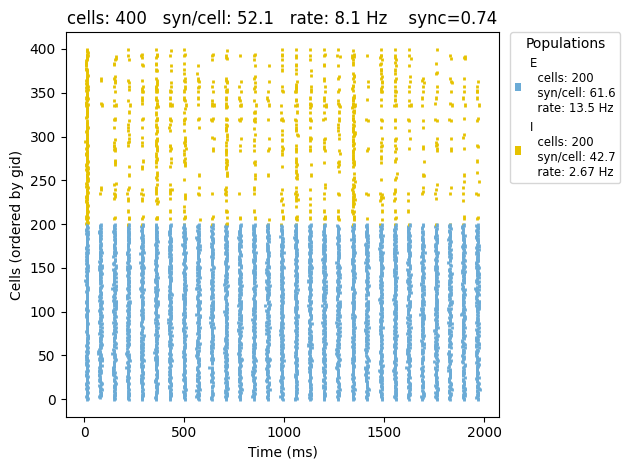

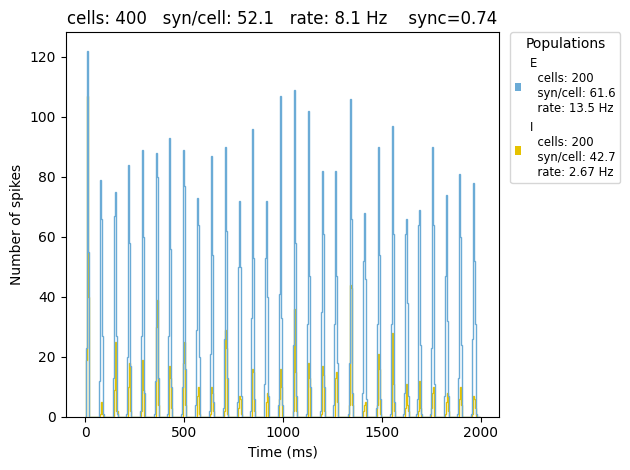

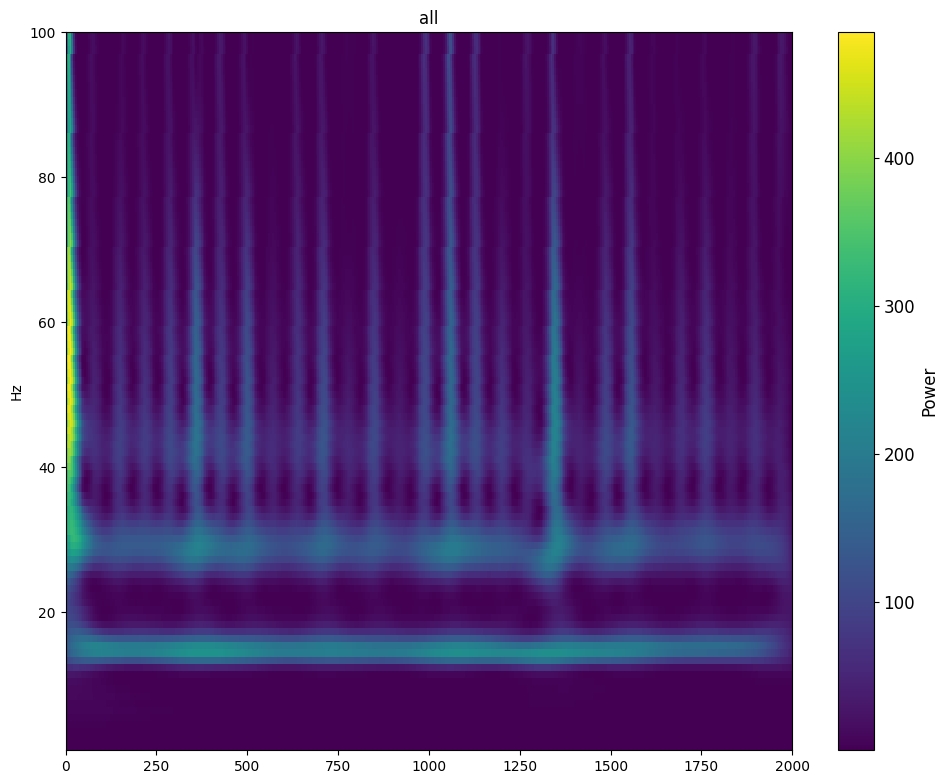

Plotting recorded cell traces ... trace


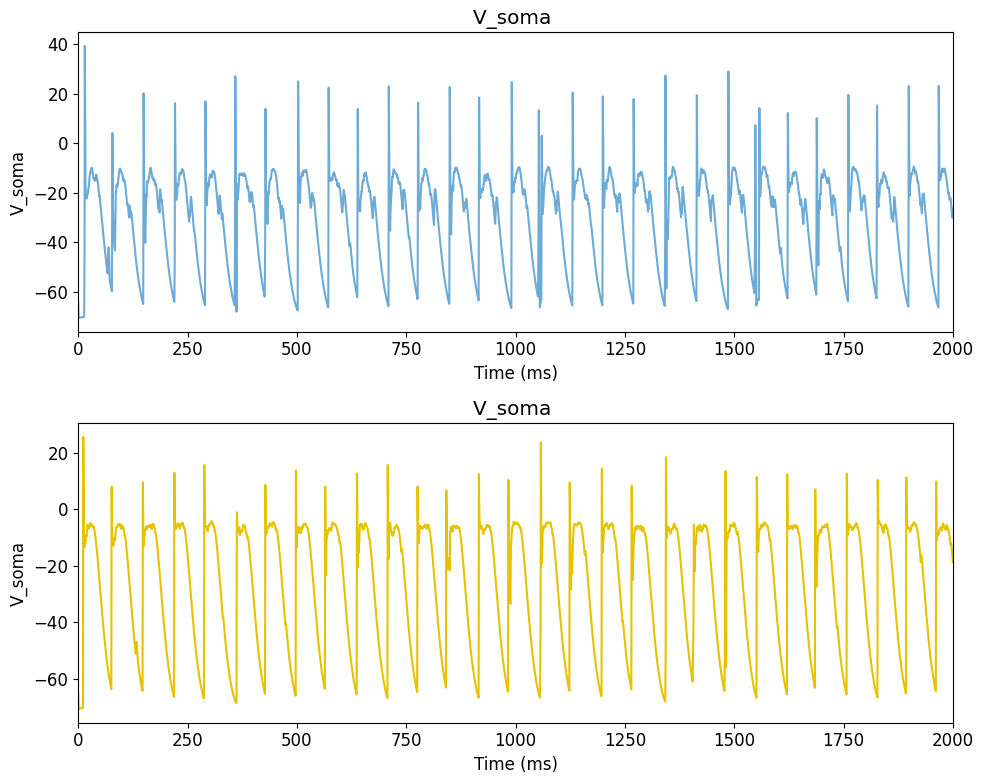

  Done; plotting time = 1.53 s

Total time = 264.48 s


In [6]:
seconds = 2
duration_ms = 1*1e3*seconds

#OG Params
# gnabar_E=0.13
# gkbar_E=0.036
# gnabar_I=0.11
# gkbar_I=0.036
# exc_synaptic_weight_multiplier=0.04
# inh_synaptic_weight=0.01

# ## Testing Oscillation Params
gnabar_E=0.2
gkbar_E=0.05
gnabar_I=0.15
gkbar_I=0.05
exc_synaptic_weight_multiplier=None
exc_synaptic_weight=0.01*10
inh_synaptic_weight=0.005*10
tau1_exc = 0.8
tau2_exc = 6.0
tau1_inh = 0.8
tau2_inh = 9.0
stim_rate = 30*0.5 #Hz
stim_noise = 0.4
delay = '(dist_3D/propVelocity)*10'

netParams = netParams
#duration_ms = 1*1e3

run_simulation(gnabar_E = gnabar_E, 
               gkbar_E = gkbar_E, 
               gnabar_I = gnabar_I, 
               gkbar_I = gkbar_I, 
               exc_synaptic_weight = exc_synaptic_weight, 
               exc_synaptic_weight_multiplier = exc_synaptic_weight_multiplier, 
               inh_synaptic_weight = inh_synaptic_weight, 
               duration_ms = duration_ms,
                tau1_exc = tau1_exc,
                tau2_exc = tau2_exc,
                tau1_inh = tau1_inh,
                tau2_inh = tau2_inh,
               stim_rate = stim_rate,
               stim_noise = stim_noise,
               delay = delay,    
               netParams = netParams)

Plotting 2D representation of network cell locations and connections...


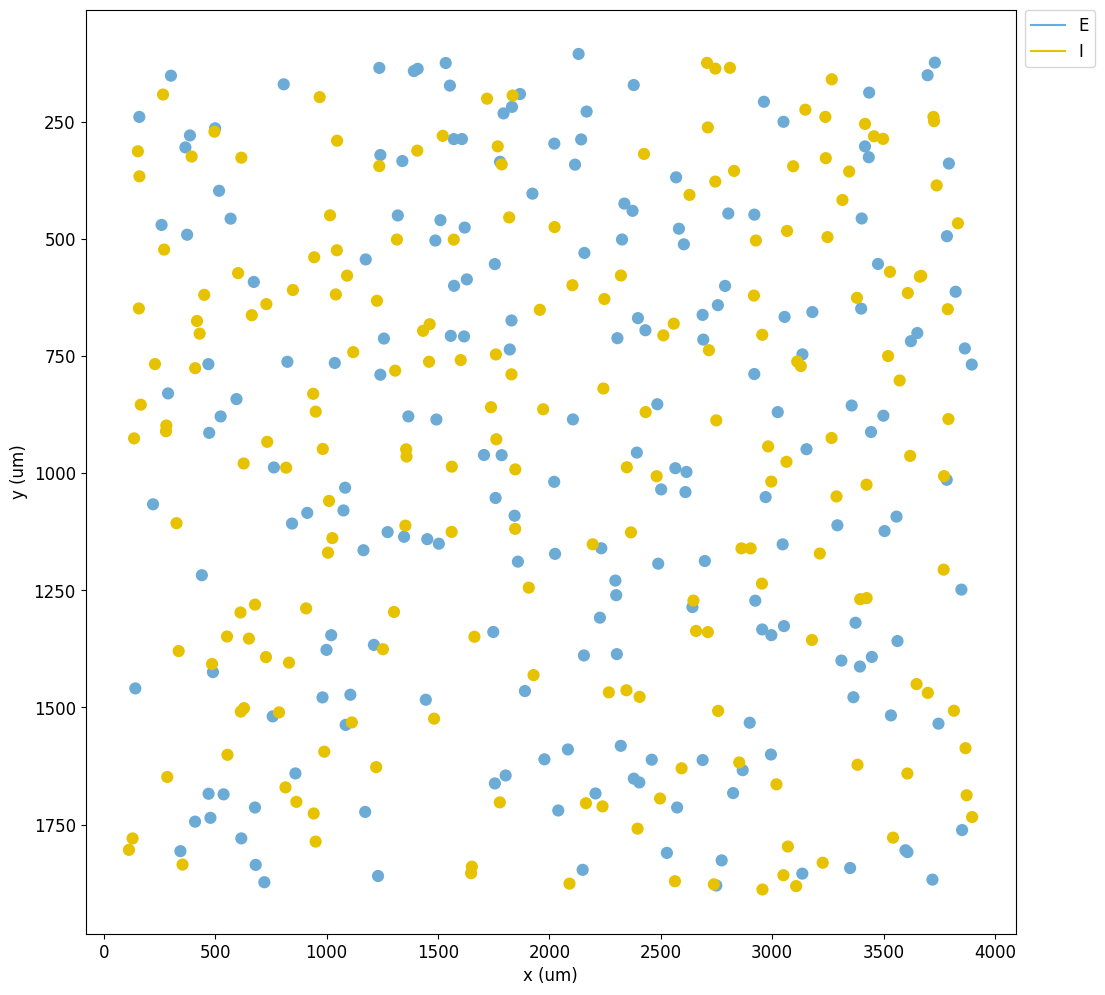

Plotting 2D representation of network cell locations and connections...


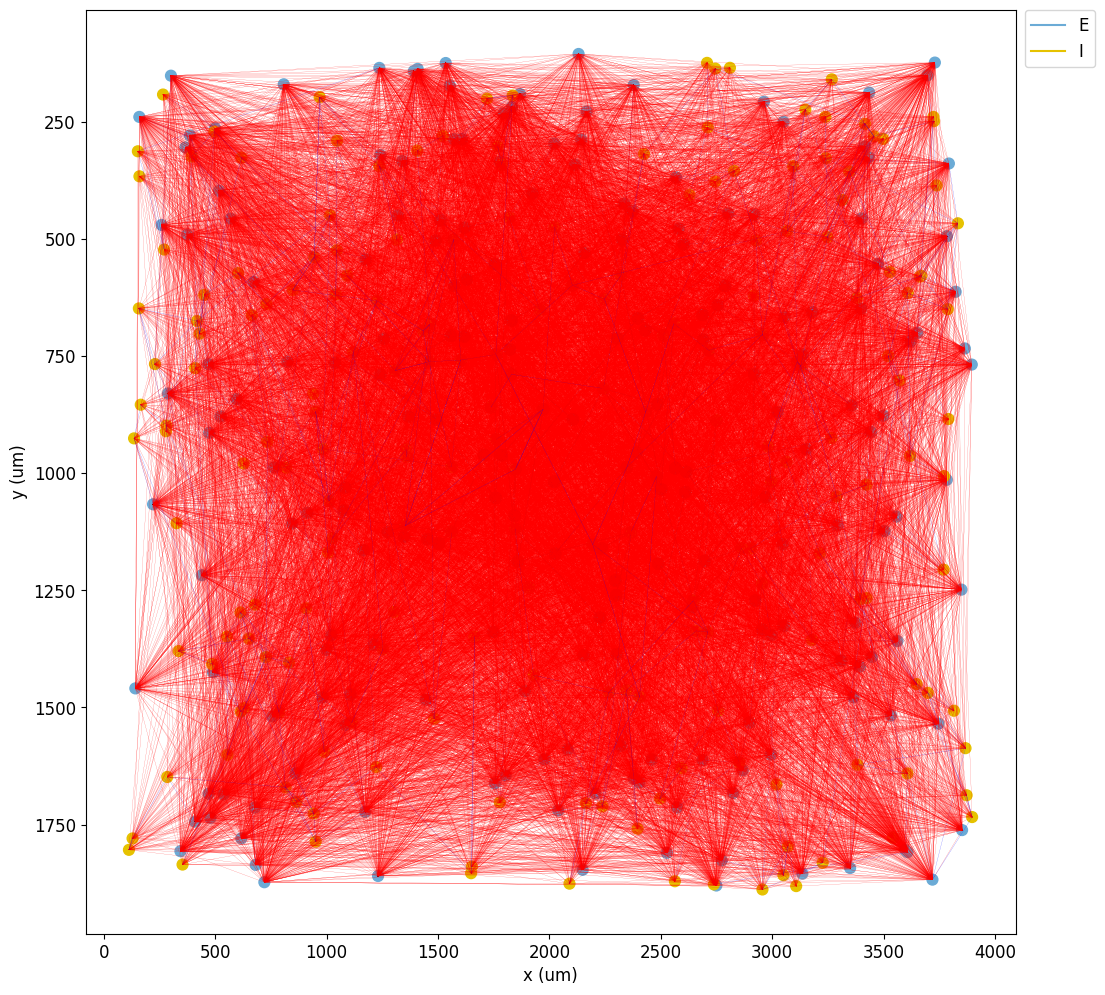

In [7]:

# Plotting 2D network with connections
#simConfig.analysis['plot2Dnet'] = {'showConns': False, 'saveFig': True}  # plot 2D cell positions and connections
positions_2D = sim.analysis.plot2Dnet(showConns=False, saveFig=fig_dir +'2Dnet_positions_all.png')

# Plotting 2D network without connections
connectivity_2D = sim.analysis.plot2Dnet(showConns=True, saveFig=fig_dir +'2Dnet_connectivity_def.png')

Plotting connectivity matrix...


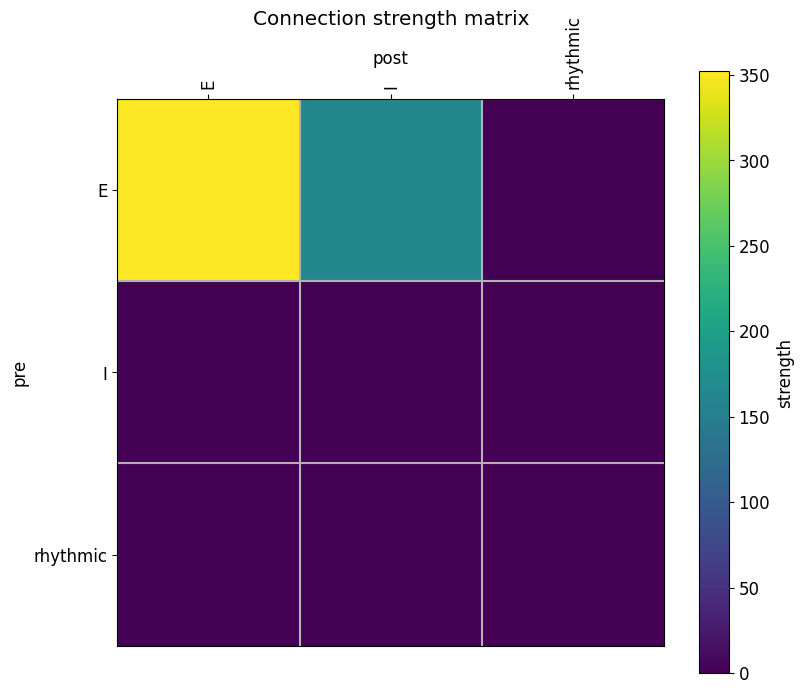

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[ 3.51886240e+02,  1.62771903e+02, -0.00000000e+00],
         [ 8.38512500e-02,  8.84450000e-02, -0.00000000e+00],
         [ 2.00000000e-02,  4.00000000e-03,  0.00000000e+00]]),
  'feature': 'strength',
  'groupBy': 'pop',
  'includePre': ['all'],
  'includePost': ['all']})

In [8]:

#plot connectivity matrix
#simConfig.analysis['plotConn'] = {'saveFig': True}  # plot connectivity matrix
sim.analysis.plotConn(saveFig=fig_dir +'2Dnet_connmatrix_def.png')

Plotting recorded cell traces ... cell


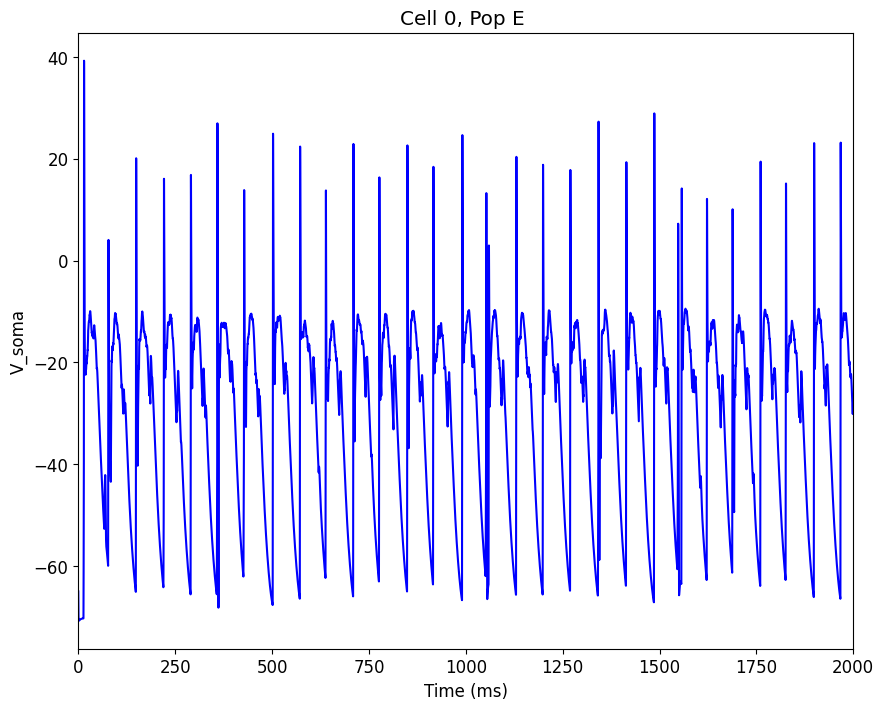

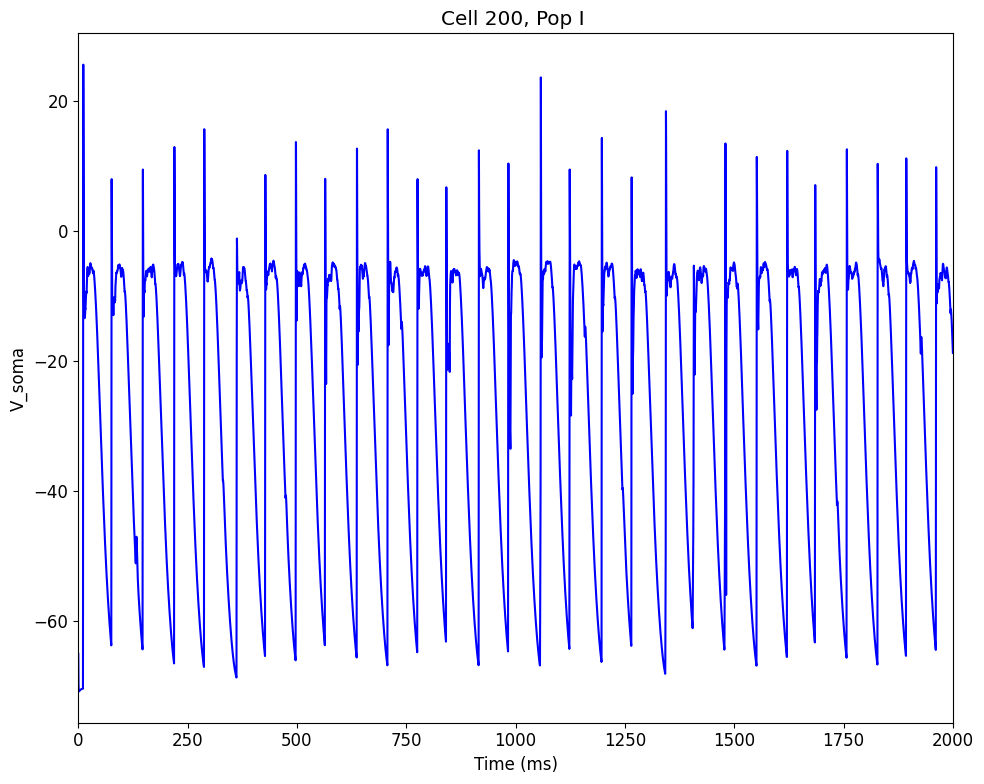

Done


In [9]:
# Generate a voltage trace plot for specific cells
include = [('E',0), ('I', 0)]
#sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)
sim.analysis.plotTraces(include = include, saveFig=fig_dir +'traces_def.png')
print('Done')

Preparing spike data...
Plotting raster...


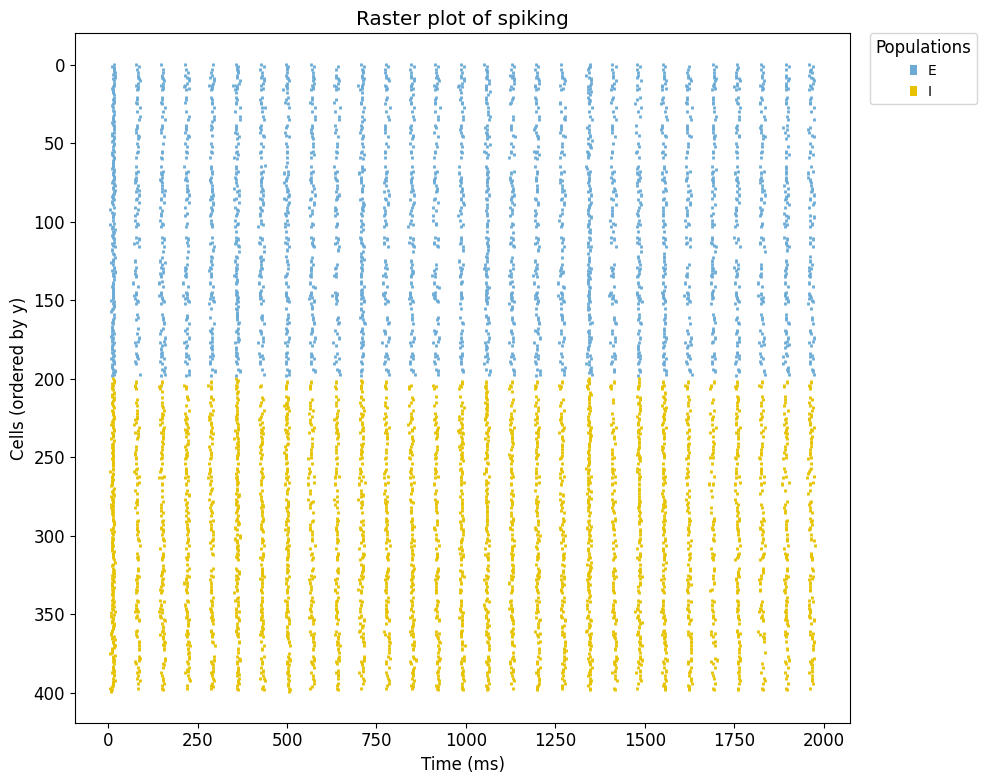

In [10]:
# plot raster
sim.analysis.plotRaster(orderBy='y', orderInverse=True, saveFig=fig_dir +'raster_def.png', showFig=True,)

In [11]:
#get raster data and parse
rasterData_def = sim.analysis.prepareRaster()

Preparing spike data...


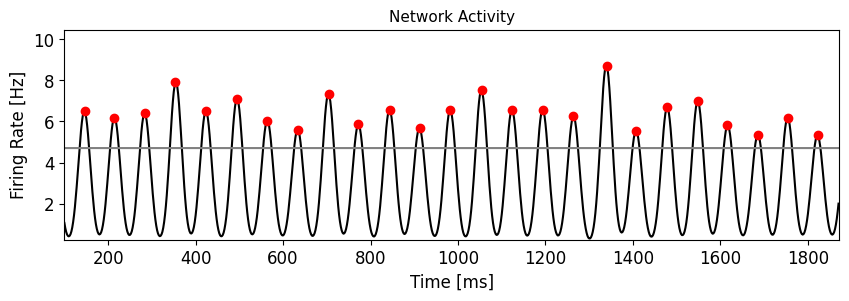

In [12]:
binSize=0.02*100
gaussianSigma=0.13*100
plot_network_activity(
    rasterData_def, 
    binSize=binSize, 
    gaussianSigma=gaussianSigma, 
    thresholdBurst=1.2, 
    #figSize=(10, 6), 
    saveFig=fig_dir +'network_activity_def.png')


# Increased Excite


Start time:  2024-02-28 11:28:15.146596

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connections on node 0: 19645 
  Number of synaptic contacts on node 0: 20458 
  Done; cell connection time = 2.59 s.
Adding stims...
  Number of stims on node 0: 400 
  Done; cell stims creation time = 0.03 s.
Recording 2 traces of 1 types on node 0

Running simulation using NEURON for 2000.0 ms...
  Done; run time = 268.51 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 0.38 s.

Analyzing...
  Cells: 400
  Connections: 20045 (50.11 per cell)
  Synaptic contacts: 20858 (52.15 per cell)
  Spikes: 5454 (6.82 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 268.51 s

Start time:  2024-02-28 11:32:46.839658

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connectio

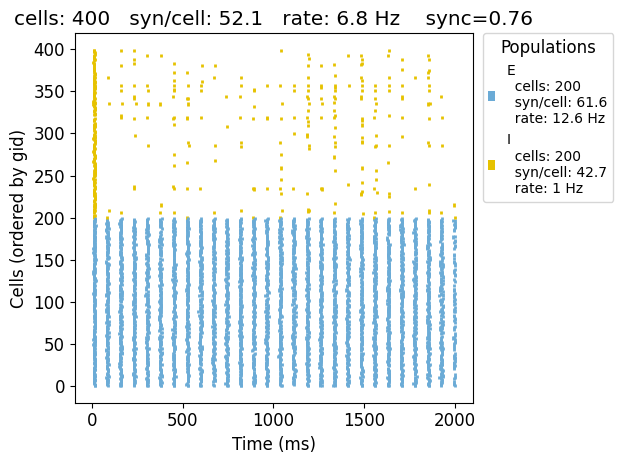

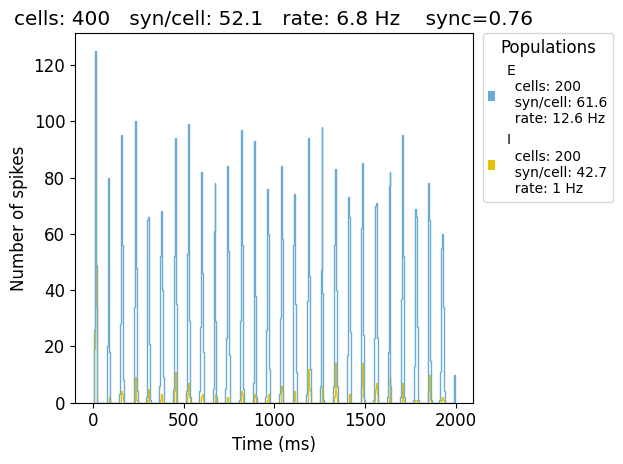

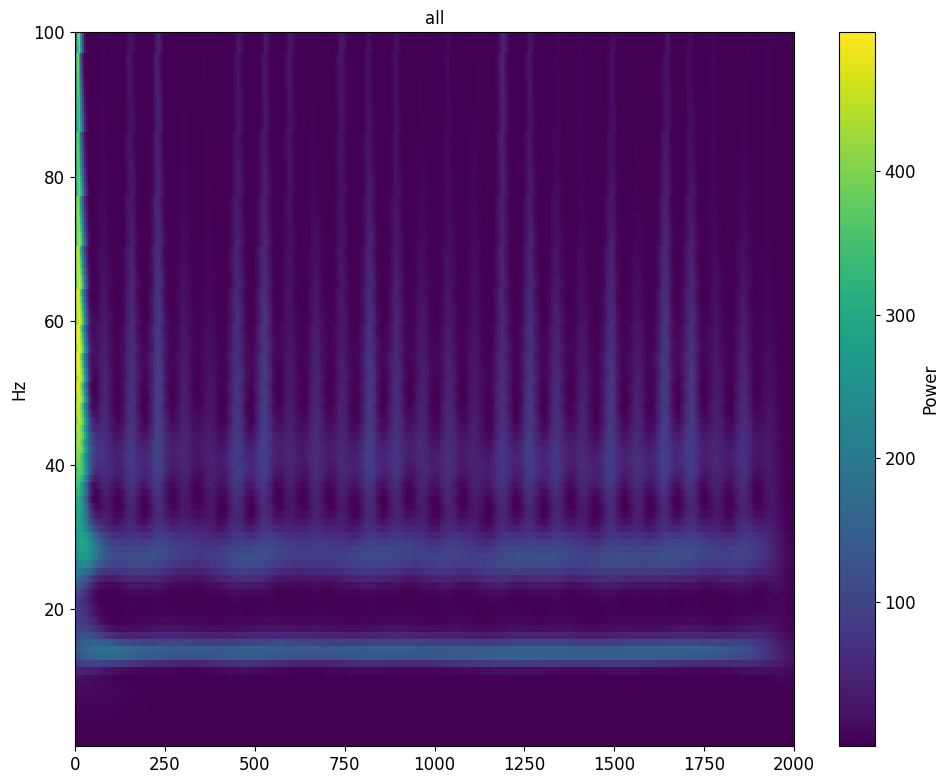

Plotting recorded cell traces ... trace


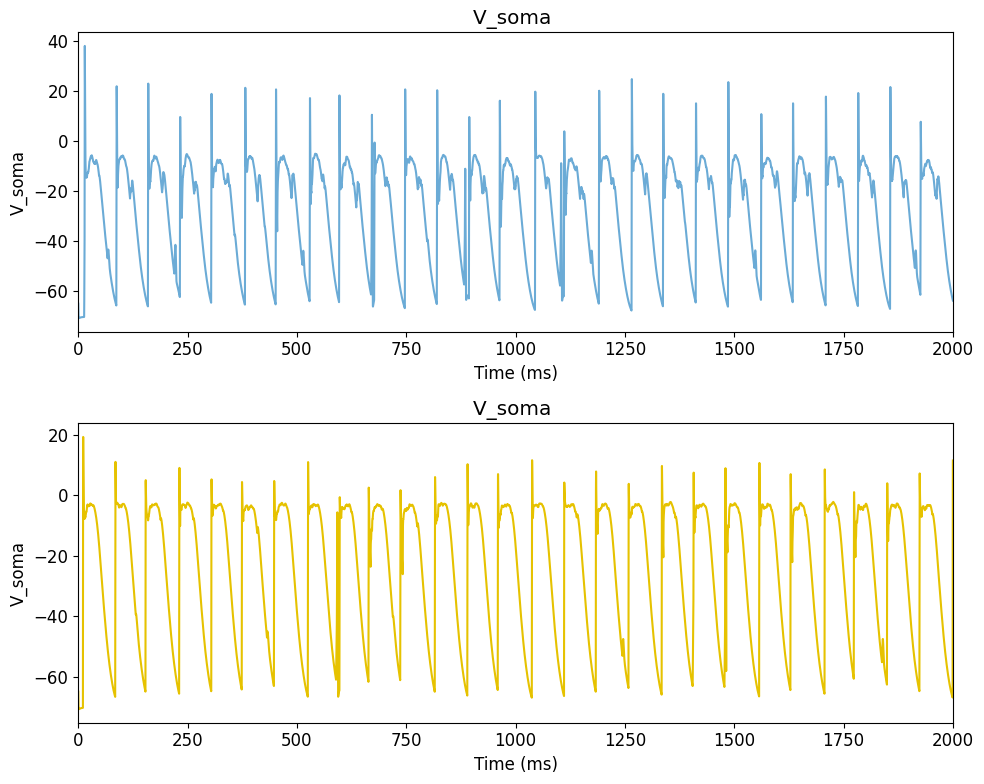

  Done; plotting time = 1.72 s

Total time = 310.32 s


In [13]:
# gnabar_E=0.13
# gkbar_E=0.036
# gnabar_I=0.11
# gkbar_I=0.036
#exc_synaptic_weight=0.005*100/2
#inh_synaptic_weight=0.005*10
#netParams = netParams


# ## Testing Oscillation Params
gnabar_E=0.2
gkbar_E=0.05
gnabar_I=0.15
gkbar_I=0.05
exc_synaptic_weight_multiplier=None
exc_synaptic_weight=0.01*10*2
inh_synaptic_weight=0.005*10
tau1_exc = 0.8
tau2_exc = 6.0
tau1_inh = 0.8
tau2_inh = 9.0
stim_rate = 30*0.5 #Hz
stim_noise = 0.4
delay = '(dist_3D/propVelocity)*10'

netParams = netParams
#duration_ms = 1*1e3

run_simulation(gnabar_E = gnabar_E, 
               gkbar_E = gkbar_E, 
               gnabar_I = gnabar_I, 
               gkbar_I = gkbar_I, 
               exc_synaptic_weight = exc_synaptic_weight, 
               exc_synaptic_weight_multiplier = exc_synaptic_weight_multiplier, 
               inh_synaptic_weight = inh_synaptic_weight, 
               duration_ms = duration_ms,
                tau1_exc = tau1_exc,
                tau2_exc = tau2_exc,
                tau1_inh = tau1_inh,
                tau2_inh = tau2_inh,
               stim_rate = stim_rate,
               stim_noise = stim_noise,
               delay = delay,    
               netParams = netParams)

Plotting 2D representation of network cell locations and connections...


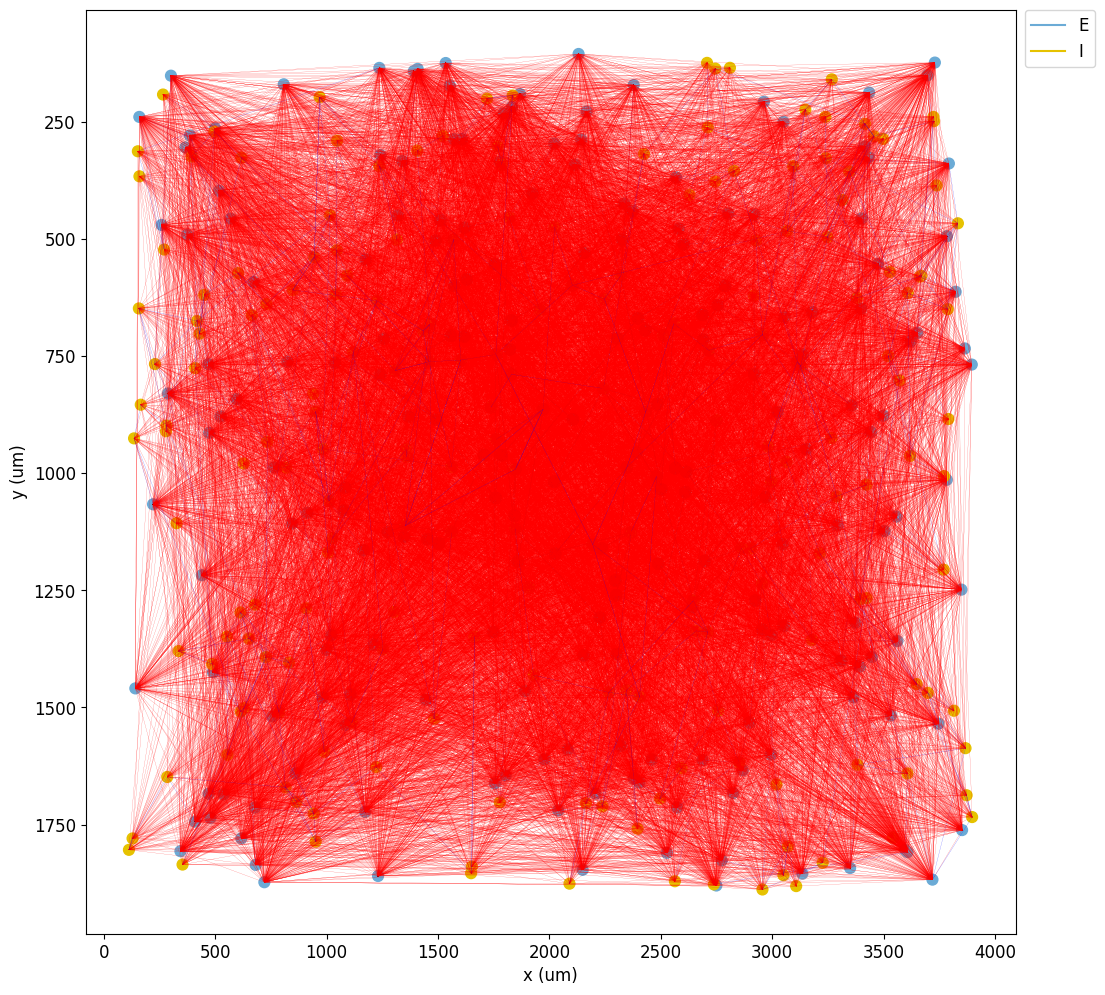

In [14]:

# Plotting 2D network with connections
#simConfig.analysis['plot2Dnet'] = {'showConns': False, 'saveFig': True}  # plot 2D cell positions and connections
#positions_2D = sim.analysis.plot2Dnet(showConns=False, saveFig='/mnt/disk15tb/adam/git_workspace/netpyne/hdmea_simulations/testing_params/2Dnet_positions_ex.png')

# Plotting 2D network without connections
connectivity_2D = sim.analysis.plot2Dnet(showConns=True,saveFig=fig_dir +'2Dnet_connectivity_ex.png')

Plotting connectivity matrix...


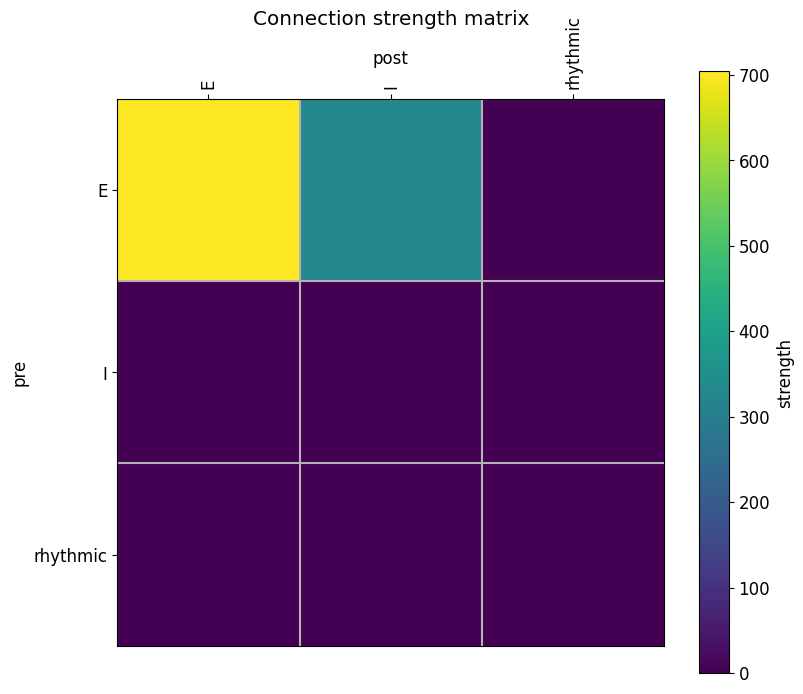

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[ 7.03772480e+02,  3.25543805e+02, -0.00000000e+00],
         [ 8.38512500e-02,  8.84450000e-02, -0.00000000e+00],
         [ 2.00000000e-02,  4.00000000e-03,  0.00000000e+00]]),
  'feature': 'strength',
  'groupBy': 'pop',
  'includePre': ['all'],
  'includePost': ['all']})

In [15]:
#plot connectivity matrix
#simConfig.analysis['plotConn'] = {'saveFig': True}  # plot connectivity matrix
sim.analysis.plotConn(saveFig=fig_dir +'2Dnet_connmatrix_ex.png')

In [16]:
# Generate a voltage trace plot for specific cells
include = [('E2',0), ('I2', 0)]
#sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)
sim.analysis.plotTraces(include = include, saveFig=fig_dir +'traces_ex.png')
print('Done')

Plotting recorded cell traces ... cell


<Figure size 640x480 with 0 Axes>

Done


Preparing spike data...
Plotting raster...


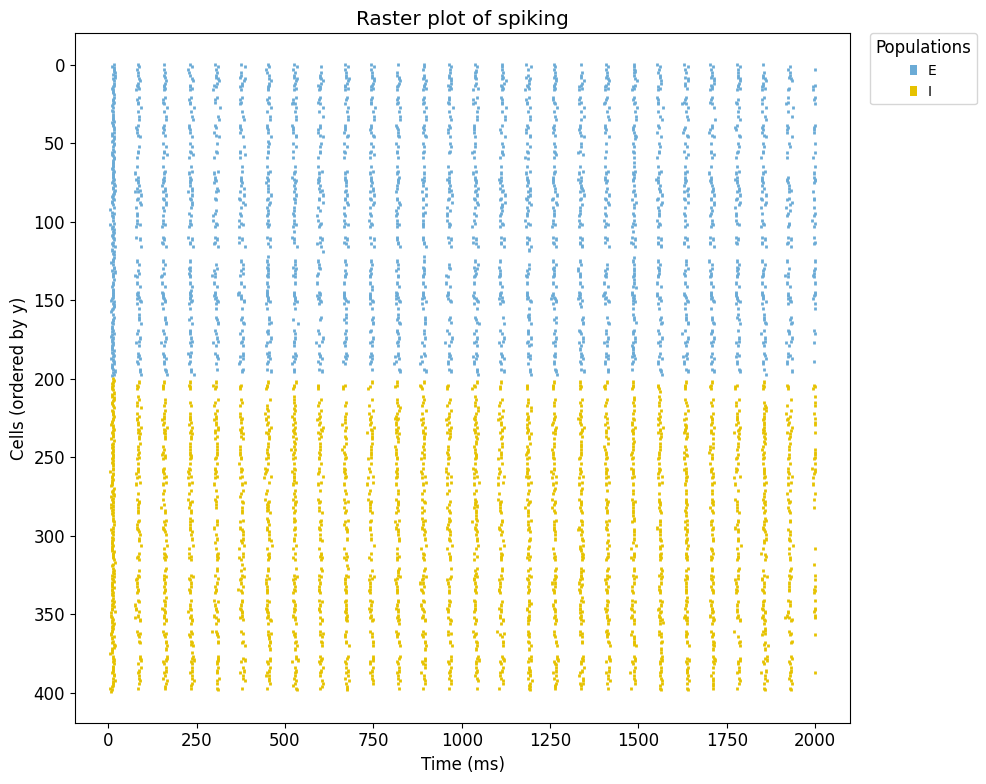

In [17]:
# plot raster
sim.analysis.plotRaster(orderBy='y', orderInverse=True, saveFig=fig_dir +'raster_ex.png', showFig=True,)

In [18]:
#get raster data and parse
rasterData_ex = sim.analysis.prepareRaster()


Preparing spike data...


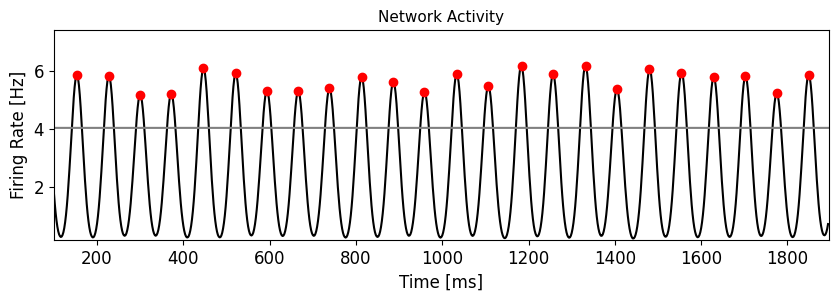

In [36]:
binSize=0.02*100
gaussianSigma=0.13*100
plot_network_activity(
    rasterData_ex, 
    binSize=binSize, 
    gaussianSigma=gaussianSigma, 
    thresholdBurst=1.2, 
    #figSize=(10, 6), 
    saveFig=fig_dir +'network_activity_ex.png')


# Increased Potassium


Start time:  2024-02-28 11:38:22.238485

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.04 s.
Making connections...
  Number of connections on node 0: 19645 
  Number of synaptic contacts on node 0: 20458 
  Done; cell connection time = 3.06 s.
Adding stims...
  Number of stims on node 0: 400 
  Done; cell stims creation time = 0.04 s.
Recording 2 traces of 1 types on node 0

Running simulation using NEURON for 2000.0 ms...
  Done; run time = 278.01 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 0.38 s.

Analyzing...
  Cells: 400
  Connections: 20045 (50.11 per cell)
  Synaptic contacts: 20858 (52.15 per cell)
  Spikes: 6207 (7.76 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 278.01 s

Start time:  2024-02-28 11:43:03.973904

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connectio

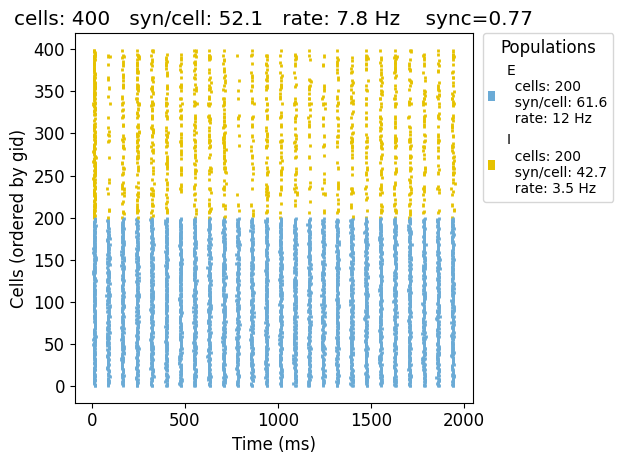

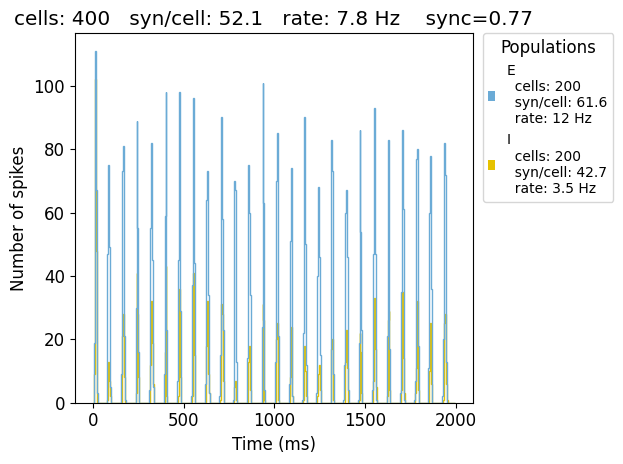

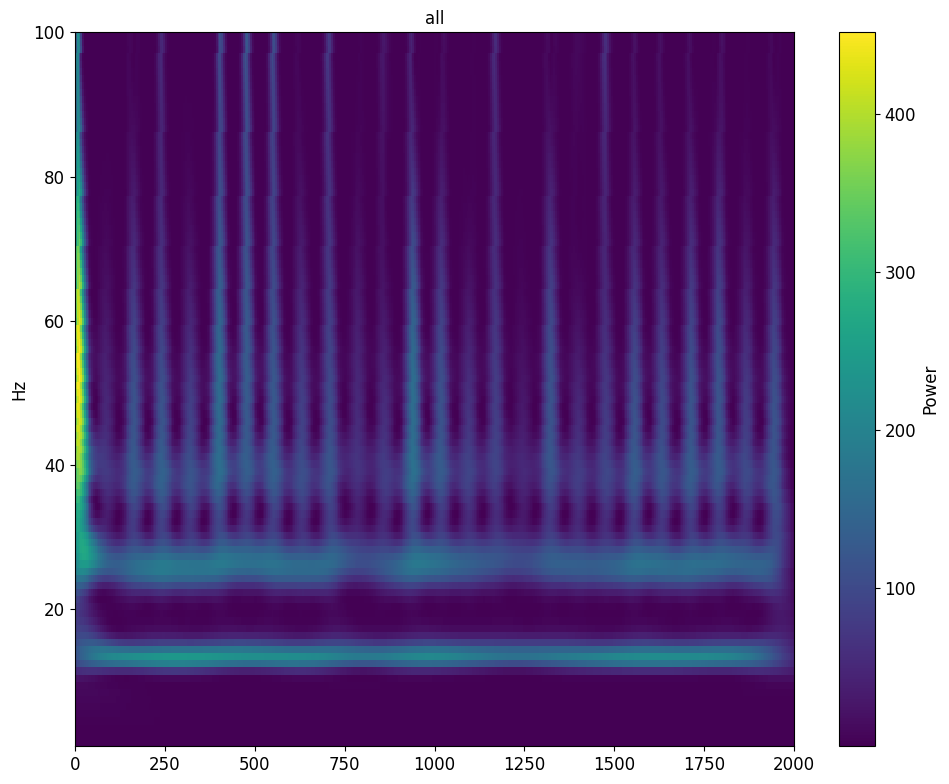

Plotting recorded cell traces ... trace


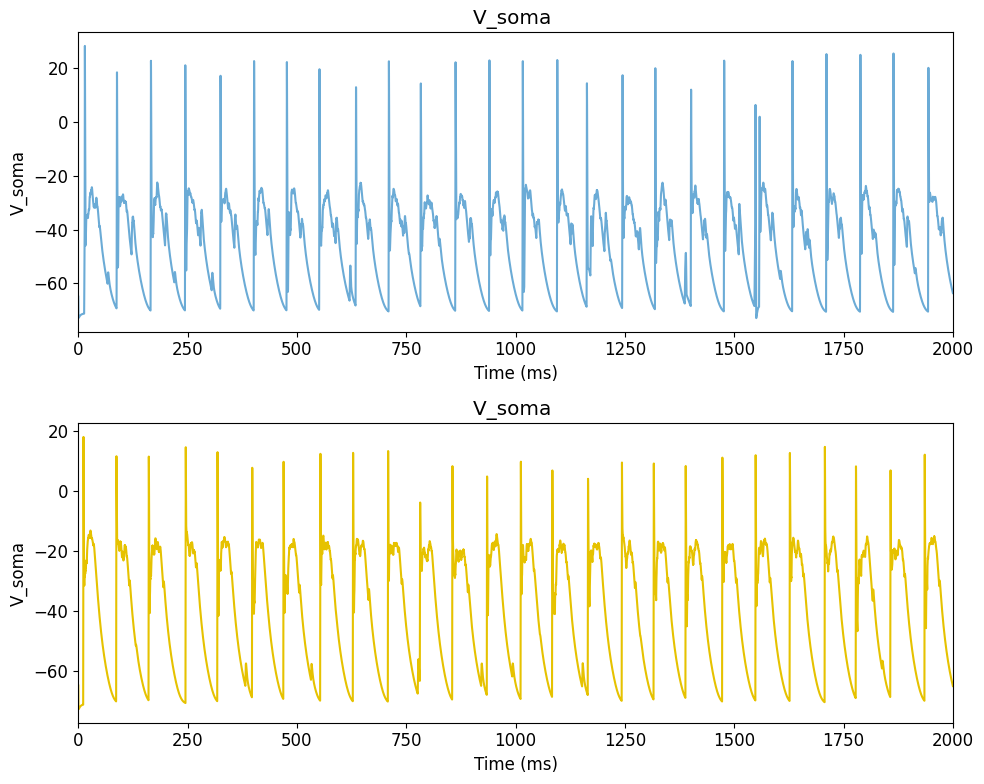

  Done; plotting time = 1.40 s

Total time = 261.44 s


In [20]:
# gnabar_E=0.13
# #gkbar_E=0.036*7 #gkbar is proportional to the number of channels
# gnabar_I=0.11
# #gkbar_I=0.036*7 #gkbar is proportional to the number of channels
# #exc_synaptic_weight=0.005
# inh_synaptic_weight=0.001
# netParams = netParams

# ## Testing Oscillation Params
gnabar_E=0.2
gkbar_E=0.05*5
gnabar_I=0.15
gkbar_I=0.05*5
exc_synaptic_weight_multiplier=None
exc_synaptic_weight=0.01*10
inh_synaptic_weight=0.005*10
tau1_exc = 0.8
tau2_exc = 6.0
tau1_inh = 0.8
tau2_inh = 9.0
stim_rate = 30*0.5 #Hz
stim_noise = 0.4
delay = '(dist_3D/propVelocity)*10'

netParams = netParams
#duration_ms = 1*1e3

run_simulation(gnabar_E = gnabar_E, 
               gkbar_E = gkbar_E, 
               gnabar_I = gnabar_I, 
               gkbar_I = gkbar_I, 
               exc_synaptic_weight = exc_synaptic_weight, 
               exc_synaptic_weight_multiplier = exc_synaptic_weight_multiplier, 
               inh_synaptic_weight = inh_synaptic_weight, 
               duration_ms = duration_ms,
                tau1_exc = tau1_exc,
                tau2_exc = tau2_exc,
                tau1_inh = tau1_inh,
                tau2_inh = tau2_inh,
               stim_rate = stim_rate,
               stim_noise = stim_noise,
               delay = delay,    
               netParams = netParams)

Plotting 2D representation of network cell locations and connections...


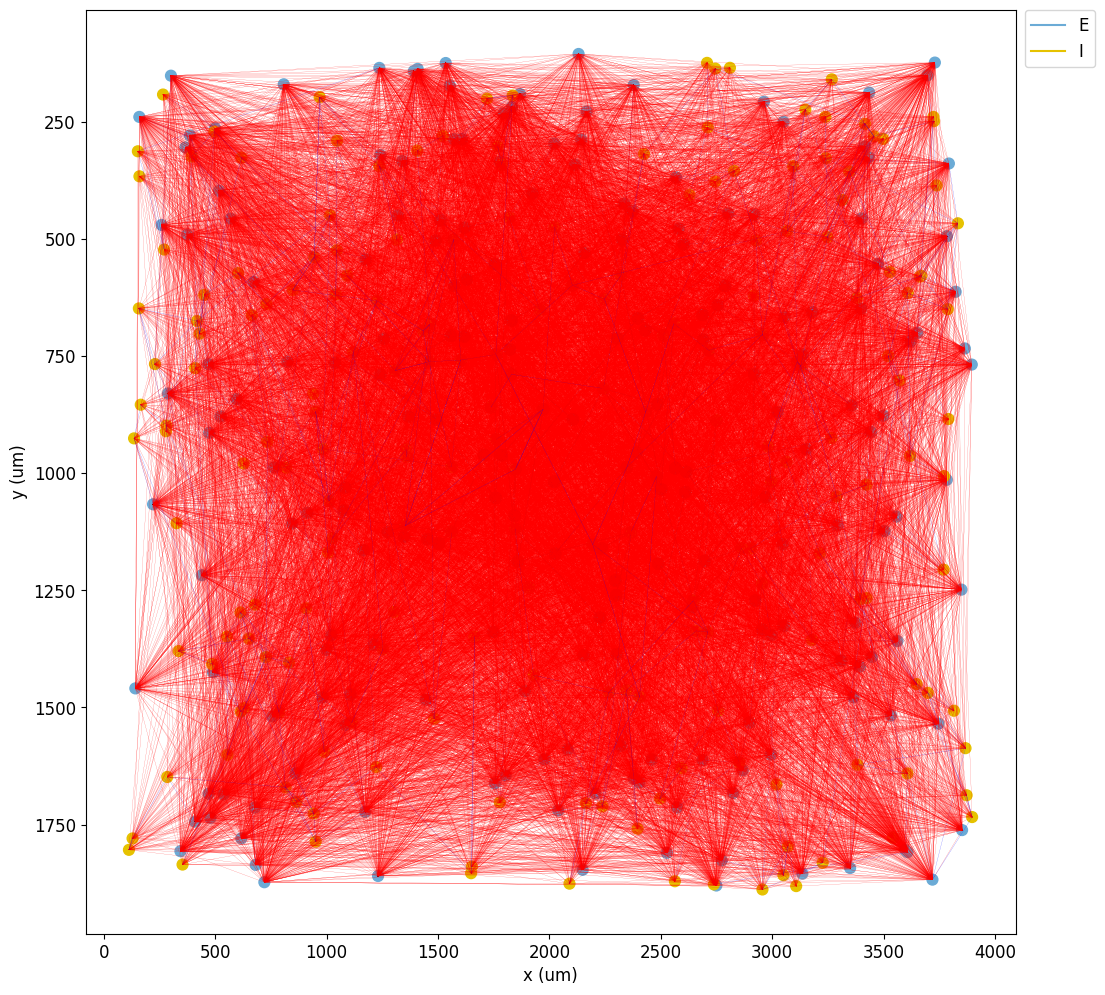

In [21]:

# Plotting 2D network with connections
#simConfig.analysis['plot2Dnet'] = {'showConns': False, 'saveFig': True}  # plot 2D cell positions and connections
# positions_2D = sim.analysis.plot2Dnet(showConns=False, saveFig='/mnt/disk15tb/adam/git_workspace/netpyne/hdmea_simulations/testing_params/2Dnet_positions_k.png')

# Plotting 2D network without connections
connectivity_2D = sim.analysis.plot2Dnet(showConns=True, saveFig=fig_dir +'2Dnet_connectivity_k.png')

Plotting connectivity matrix...


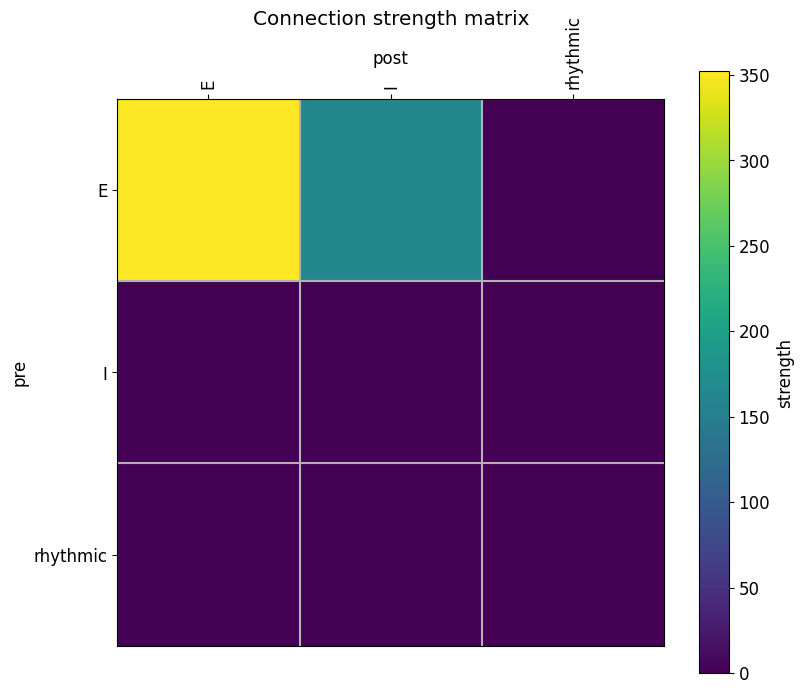

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[ 3.51886240e+02,  1.62771903e+02, -0.00000000e+00],
         [ 8.38512500e-02,  8.84450000e-02, -0.00000000e+00],
         [ 2.00000000e-02,  4.00000000e-03,  0.00000000e+00]]),
  'feature': 'strength',
  'groupBy': 'pop',
  'includePre': ['all'],
  'includePost': ['all']})

In [22]:

#plot connectivity matrix
#simConfig.analysis['plotConn'] = {'saveFig': True}  # plot connectivity matrix
sim.analysis.plotConn(saveFig=fig_dir +'2Dnet_connmatrix_k.png')

In [23]:
# Generate a voltage trace plot for specific cells
include = [('E2',0), ('I2', 0)]
#sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)
sim.analysis.plotTraces(include = include, saveFig=fig_dir +'traces_k.png')
print('Done')

Plotting recorded cell traces ... cell


<Figure size 640x480 with 0 Axes>

Done


Preparing spike data...
Plotting raster...


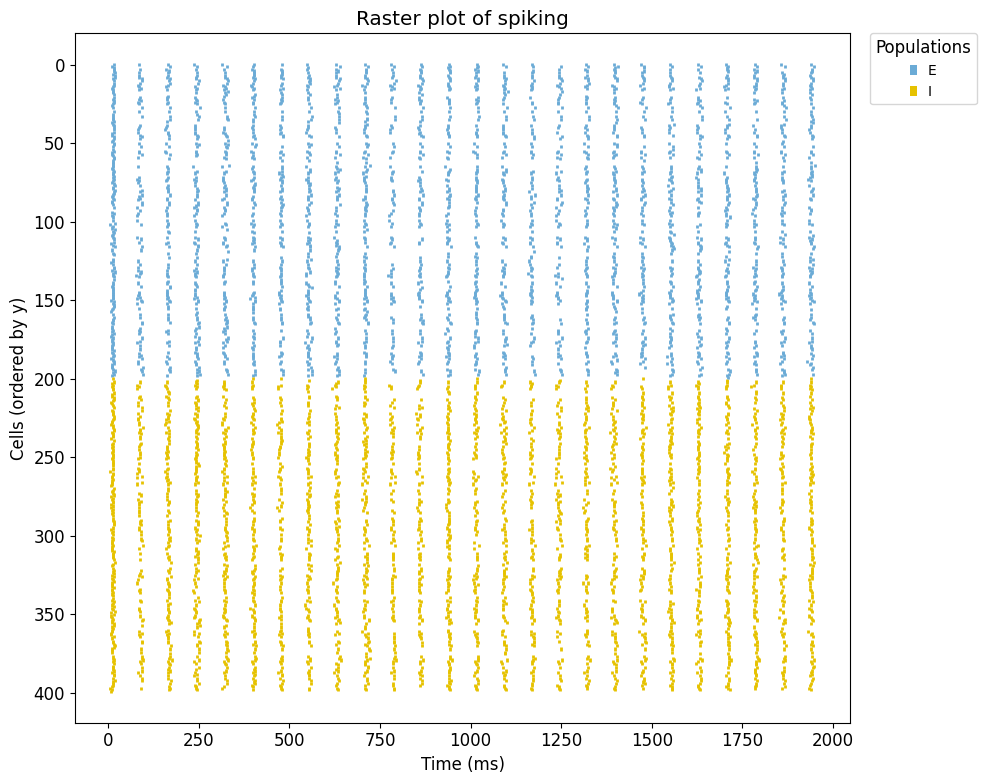

In [24]:
# plot raster
sim.analysis.plotRaster(orderBy='y', orderInverse=True, saveFig=fig_dir +'raster_k.png', showFig=True,)

In [25]:
#get raster data and parse
rasterData_k = sim.analysis.prepareRaster()


Preparing spike data...


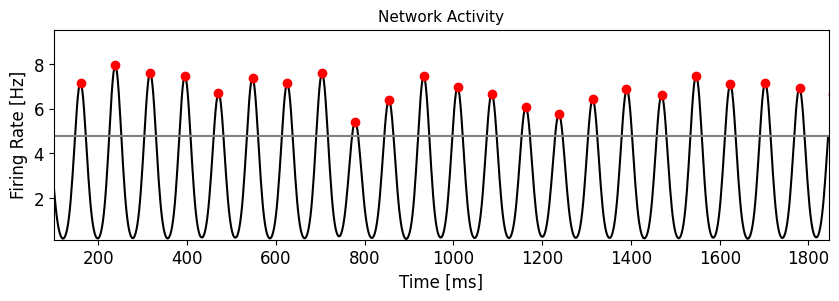

In [35]:
binSize=0.02*100
gaussianSigma=0.13*100
plot_network_activity(
    rasterData_k, 
    binSize=binSize, 
    gaussianSigma=gaussianSigma, 
    thresholdBurst=1.2, 
    #figSize=(10, 6), 
saveFig=fig_dir +'network_activity_k.png')


# Increased Inhib


Start time:  2024-02-28 11:47:46.130990

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connections on node 0: 19645 
  Number of synaptic contacts on node 0: 20458 
  Done; cell connection time = 2.56 s.
Adding stims...
  Number of stims on node 0: 400 
  Done; cell stims creation time = 0.03 s.
Recording 2 traces of 1 types on node 0

Running simulation using NEURON for 2000.0 ms...
  Done; run time = 259.77 s; real-time ratio: 0.01.

Gathering data...
  Done; gather time = 0.38 s.

Analyzing...
  Cells: 400
  Connections: 20045 (50.11 per cell)
  Synaptic contacts: 20858 (52.15 per cell)
  Spikes: 6401 (8.00 Hz)
  Simulated time: 2.0 s; 1 workers
  Run time: 259.77 s

Start time:  2024-02-28 11:52:09.054266

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 400 
  Done; cell creation time = 0.03 s.
Making connections...
  Number of connectio

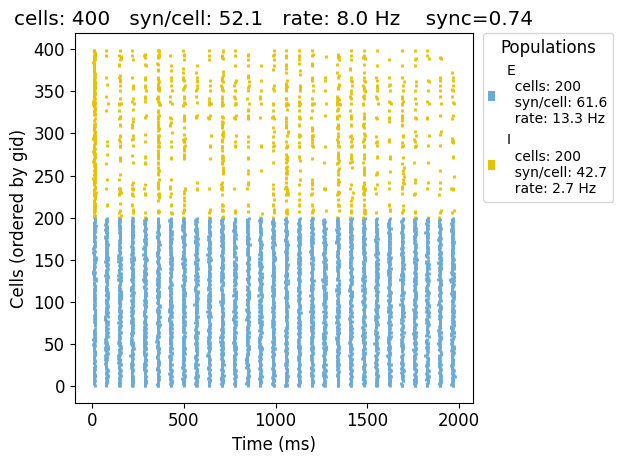

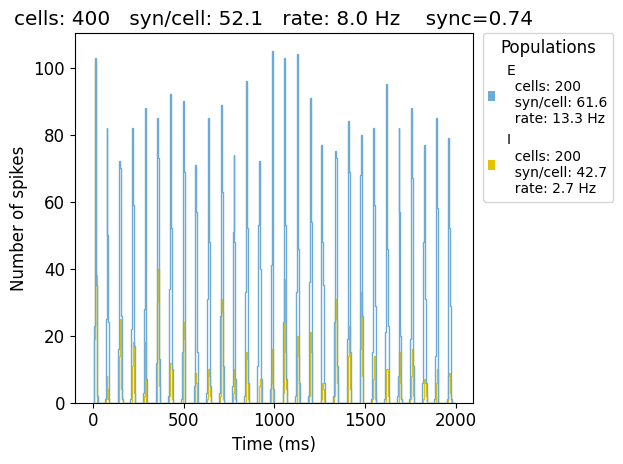

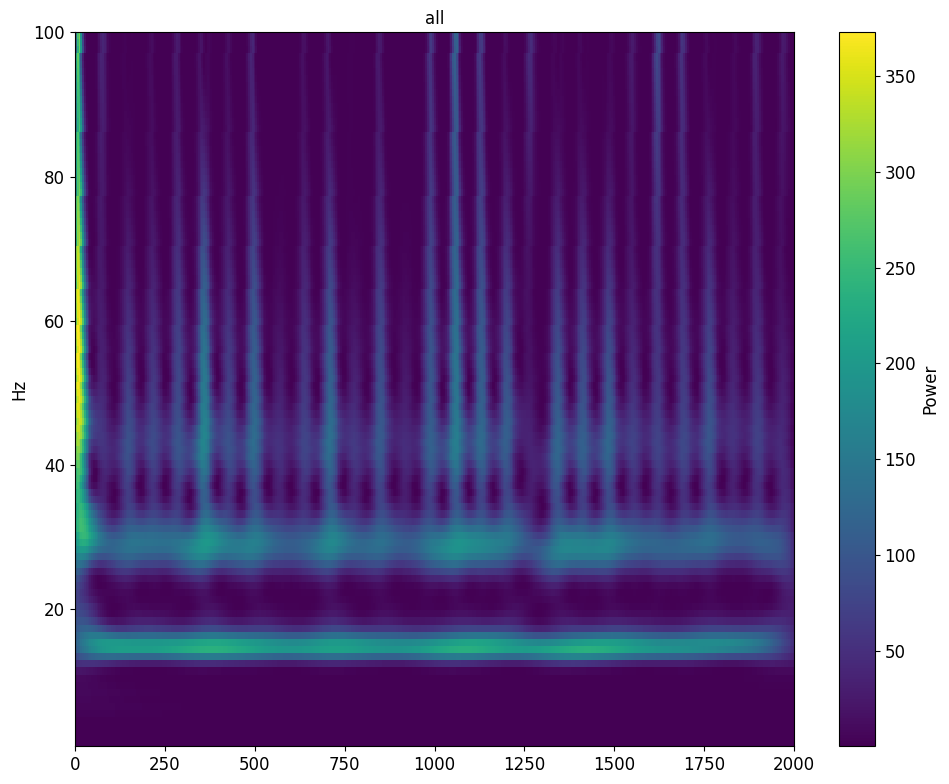

Plotting recorded cell traces ... trace


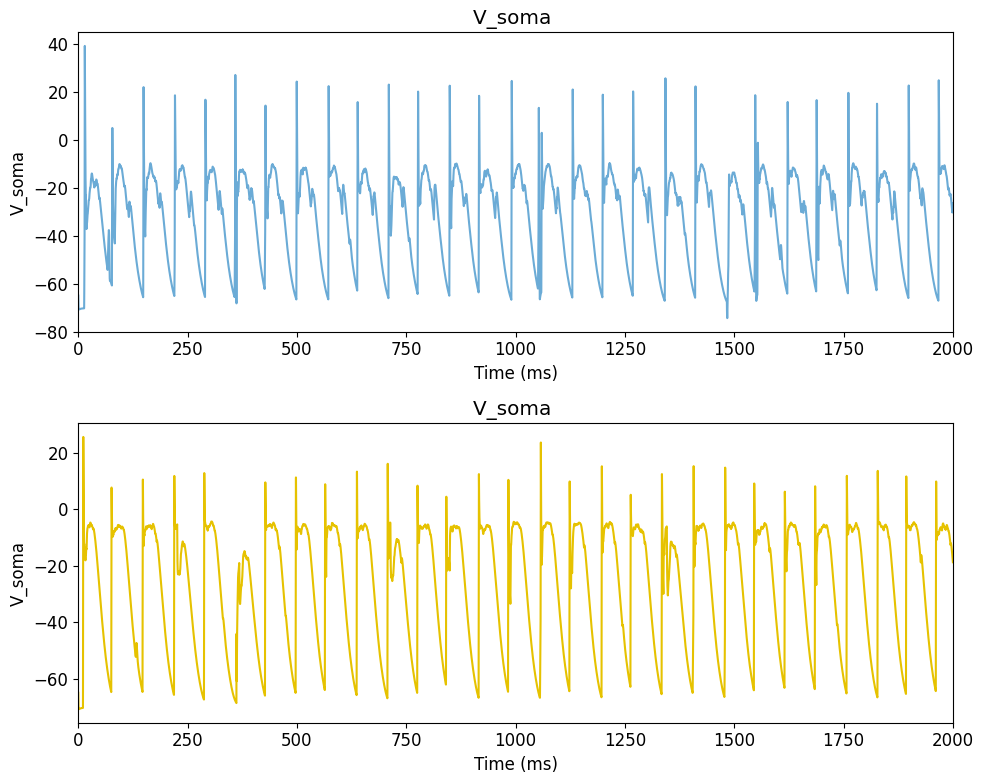

  Done; plotting time = 1.47 s

Total time = 267.20 s


In [27]:
# gnabar_E=0.13
# gkbar_E=0.036
# gnabar_I=0.11
# gkbar_I=0.036
# exc_synaptic_weight=0.005
# inh_synaptic_weight=0.001*100
# netParams = netParams

# ## Testing Oscillation Params
gnabar_E=0.2
gkbar_E=0.05
gnabar_I=0.15
gkbar_I=0.05
exc_synaptic_weight_multiplier=None
exc_synaptic_weight=0.01*10
inh_synaptic_weight=0.005*100
tau1_exc = 0.8
tau2_exc = 6.0
tau1_inh = 0.8
tau2_inh = 9.0
stim_rate = 30*0.5 #Hz
stim_noise = 0.4
delay = '(dist_3D/propVelocity)*10'

netParams = netParams
#duration_ms = 1*1e3

run_simulation(gnabar_E = gnabar_E, 
               gkbar_E = gkbar_E, 
               gnabar_I = gnabar_I, 
               gkbar_I = gkbar_I, 
               exc_synaptic_weight = exc_synaptic_weight, 
               exc_synaptic_weight_multiplier = exc_synaptic_weight_multiplier, 
               inh_synaptic_weight = inh_synaptic_weight, 
               duration_ms = duration_ms,
                tau1_exc = tau1_exc,
                tau2_exc = tau2_exc,
                tau1_inh = tau1_inh,
                tau2_inh = tau2_inh,
               stim_rate = stim_rate,
               stim_noise = stim_noise,
               delay = delay,    
               netParams = netParams)

Plotting 2D representation of network cell locations and connections...


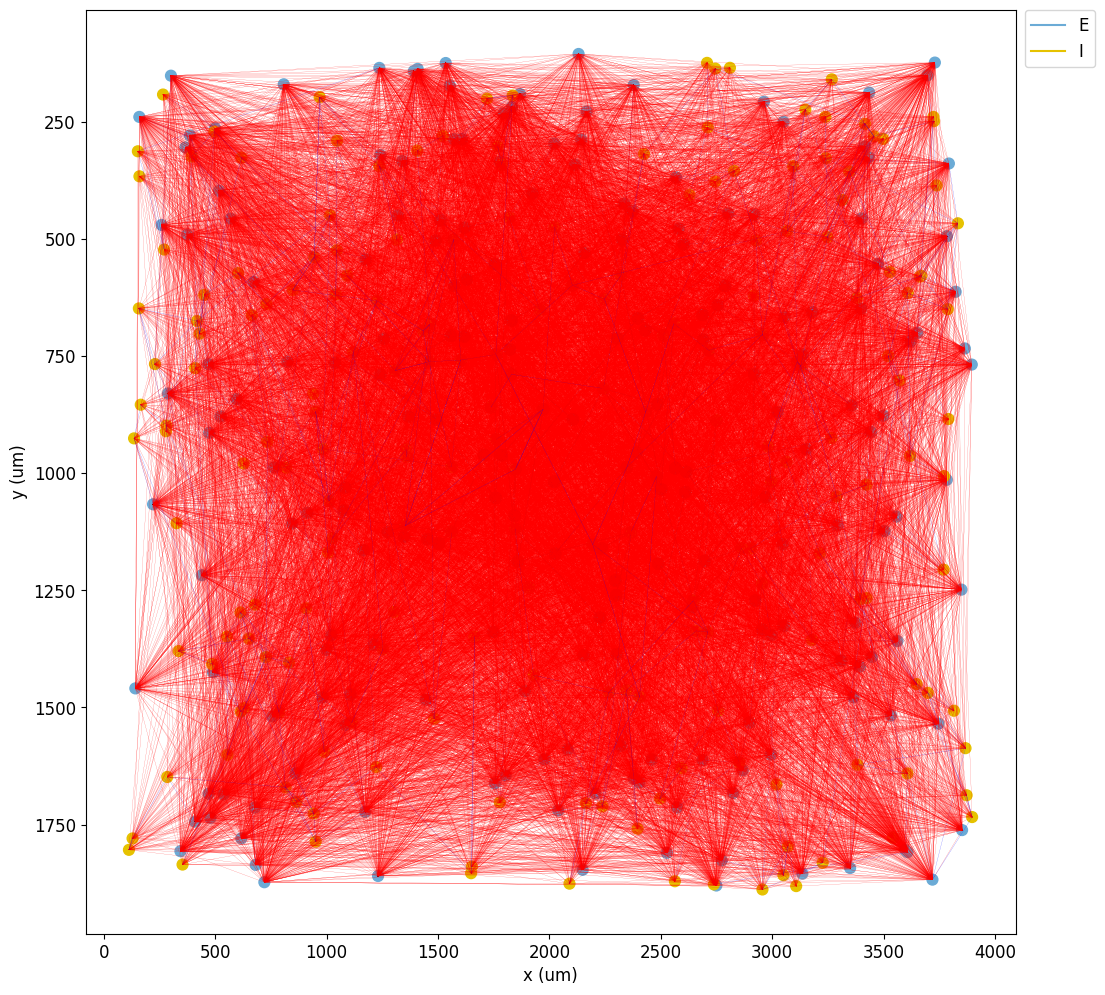

In [28]:

# Plotting 2D network with connections
#simConfig.analysis['plot2Dnet'] = {'showConns': False, 'saveFig': True}  # plot 2D cell positions and connections
# positions_2D = sim.analysis.plot2Dnet(showConns=False, saveFig='/mnt/disk15tb/adam/git_workspace/netpyne/hdmea_simulations/testing_params/2Dnet_positions_inhib.png')

# Plotting 2D network without connections
connectivity_2D = sim.analysis.plot2Dnet(showConns=True,saveFig=fig_dir +'2Dnet_connectivity_inhib.png')

Plotting connectivity matrix...


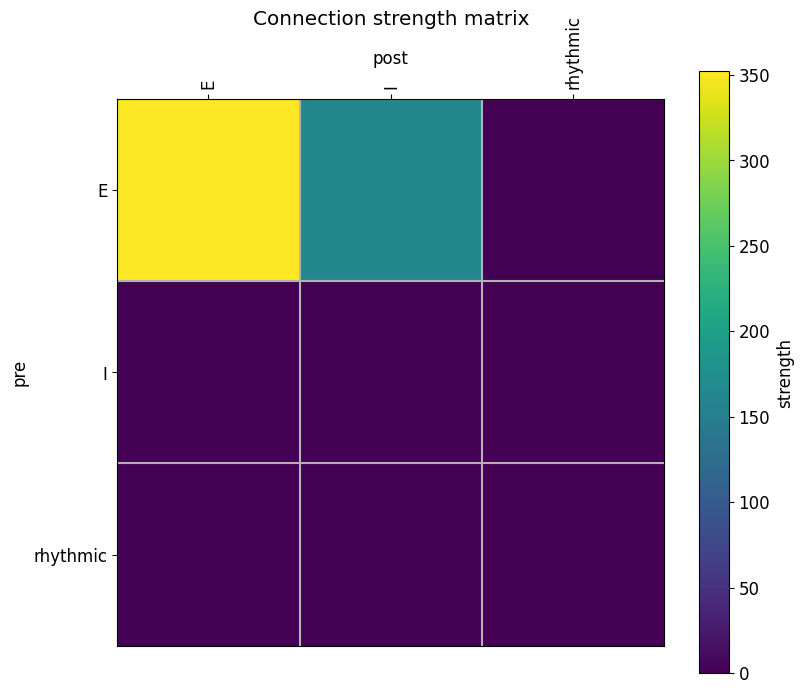

(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[ 3.51886240e+02,  1.62771903e+02, -0.00000000e+00],
         [ 8.38512500e-01,  8.84450000e-01, -0.00000000e+00],
         [ 2.00000000e-02,  4.00000000e-03,  0.00000000e+00]]),
  'feature': 'strength',
  'groupBy': 'pop',
  'includePre': ['all'],
  'includePost': ['all']})

In [29]:

#plot connectivity matrix
#simConfig.analysis['plotConn'] = {'saveFig': True}  # plot connectivity matrix
sim.analysis.plotConn(saveFig=fig_dir +'2Dnet_connmatrix_inhib.png')

In [30]:
# Generate a voltage trace plot for specific cells
include = [('E2',0), ('I2', 0)]
#sim.createSimulate(netParams = netParams, simConfig = simConfig, output = True)
sim.analysis.plotTraces(include = include, saveFig=fig_dir +'traces_inhib.png')
print('Done')

Plotting recorded cell traces ... cell


<Figure size 640x480 with 0 Axes>

Done


Preparing spike data...
Plotting raster...


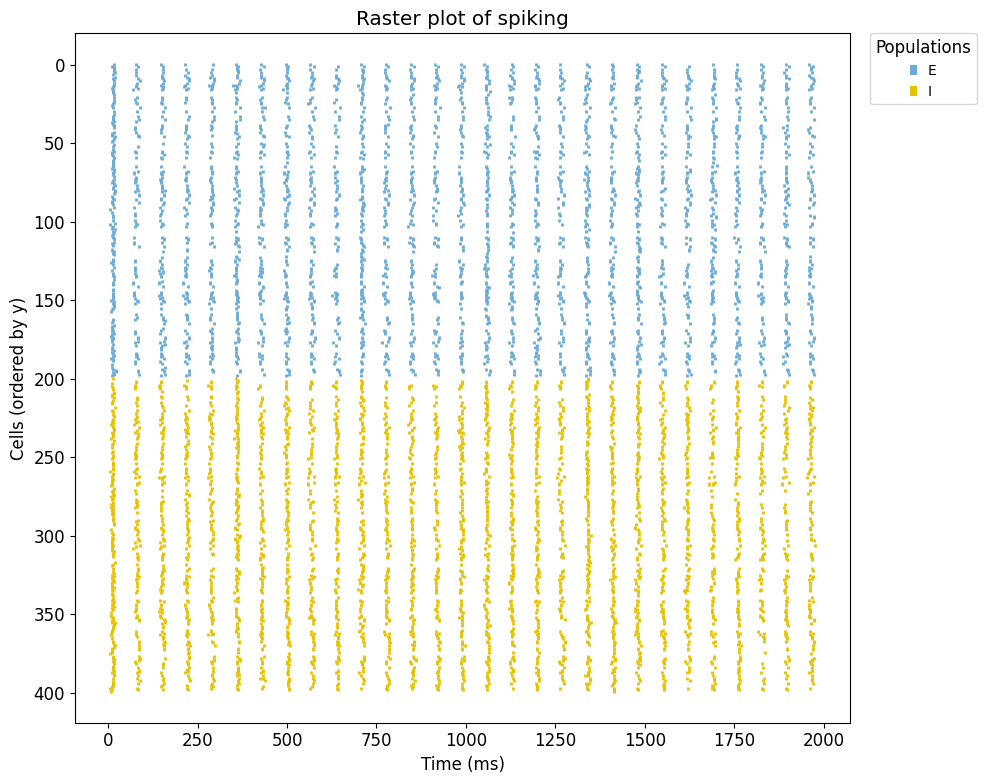

In [31]:
# plot raster
sim.analysis.plotRaster(orderBy='y', orderInverse=True, saveFig=fig_dir +'raster_k.png', showFig=True,)

In [32]:
#get raster data and parse
rasterData_inhib = sim.analysis.prepareRaster()


Preparing spike data...


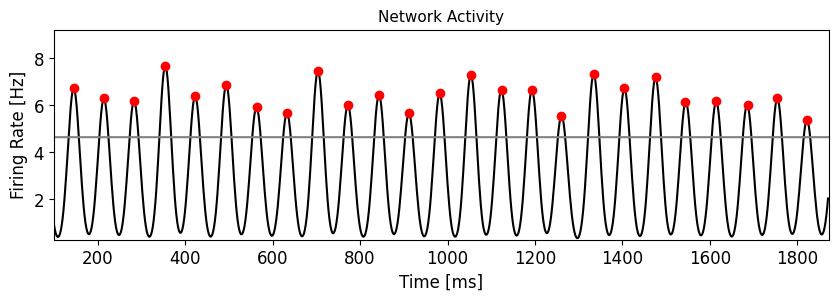

In [34]:
binSize=0.02*100
gaussianSigma=0.13*100
plot_network_activity(
    rasterData_inhib, 
    binSize=binSize, 
    gaussianSigma=gaussianSigma, 
    thresholdBurst=1.2, 
    #figSize=(10, 6), 
    saveFig=fig_dir +'network_activity_inhib.png')
